In [33]:
import sys
sys.path.append("../")

from models.samplers.normal import NormalSampler, MultimodalNormalSampler, NormalPathSampler,\
    RegressionSelectionSampler
from models.samplers.ising import MeanFieldIsingSampler
from models.samplers.logistic_regression import LogisticRegressionSampler
from models.samplers.random_effects import RandomEffectsSampler

from smc.utils import load_pima_indians_data, log_weights_to_weights, effective_sample_size
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Univariate Normal Sampler

In [2]:
D = 10
mean = np.arange(D).astype(float)
cov = stats.wishart(df= 2*D, scale =np.eye(D)).rvs(1)
normal_smc = NormalSampler(mean, cov)

Loading Stan model...


### Compare a few sampling types

In [42]:
path = [(beta,) for beta in np.linspace(0.01,1,10)]
output = normal_smc.sampling(path, 50, method='smc', save_all_samples=False)

weights = log_weights_to_weights(output[1])
estimate = (output[0]*weights[:, None]).sum(0)
print '\nSMC MSE: {0:.2f}'.format(((estimate-np.arange(D))**2).mean())

% complete:  22 55 88 100 
Elapsed time: 1.3 seconds.

SMC MSE: 0.46


In [47]:
path = [(beta,) for beta in np.linspace(0.01,1,10)]
output = normal_smc.sampling(path, 50, method='adaptive_smc', save_all_samples=False)

weights = log_weights_to_weights(output[1])
estimate = (output[0]*weights[:, None]).sum(0)
print '\nESS: {0:.2f}'.format(effective_sample_size(weights))
print 'Adaptive MSE: {0:.2f}'.format(((estimate-np.arange(D))**2).mean())

% complete:  22 55 88 100 
Elapsed time: 1.3 seconds.

ESS: 0.82
Adaptive MSE: 0.36


In [44]:
path = [(beta,) for beta in np.linspace(0.01,1,10)]
output = normal_smc.sampling(path, 50, method='ais', save_all_samples=False)

weights = log_weights_to_weights(output[1])
print '\nESS: {0:.2f}'.format(effective_sample_size(weights))
estimate = (output[0]*weights[:, None]).sum(0)
print 'AIS MSE: {0:.2f}'.format(((estimate-np.arange(D))**2).mean())
print 'No weight MSE: {0:.2f}'.format(((output[0].mean(0)-np.arange(D))**2).mean())

% complete:  22 55 88 100 
Elapsed time: 1.3 seconds.

ESS: 0.02
AIS MSE: 5.48
No weight MSE: 0.37


In [45]:
path = [(beta,) for beta in np.linspace(0.01,1,10)]
output = normal_smc.sampling(path, 50, method='multilevel_mcmc', save_all_samples=False)

weights = log_weights_to_weights(output[1])
estimate = (output[0]*weights[:, None]).sum(0)
print '\nMultilevel MSE: {0:.2f}'.format(((estimate-np.arange(D))**2).mean())

% complete:  22 55 88 100 
Elapsed time: 1.3 seconds.

Multilevel MSE: 0.37


### Multimodal Normal Sampler

In [6]:
means = (5.0,-5.0)
scales = (1.0, 1.0)
probability = 0.5
dimension = 2

multimodal_smc = MultimodalNormalSampler(means, scales, probability, dimension)

Loading Stan model...


In [7]:
S = 20 # number of steps to take
N = 1000 # number of samples to use
path = [(beta,) for beta in np.linspace(0.01,1,S+1)]
output = multimodal_smc.sampling(path, N , save_all_samples=True)

% complete:  10 25 40 55 70 85 100 
Elapsed time: 10.0 seconds.


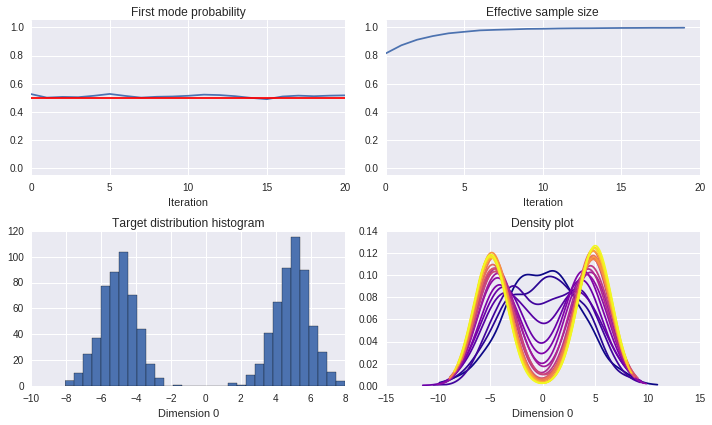

In [8]:
multimodal_smc.plot_diagnostics(output)

### Normal path sampler

In [9]:
D = 10
mean1 = np.zeros(D); mean2 = mean1 + 5
rng = stats.wishart(df=2*D, scale=np.eye(D))
covariance1, covariance2 = rng.rvs(2); 
normal_path_smc = NormalPathSampler(mean1, mean2, covariance1, covariance2)

Loading Stan model...


In [10]:
S = 20 # number of steps to take
N = 1000 # number of samples to use
path = [(beta,1.0) for beta in np.linspace(0,1,S+1)]
output = normal_path_smc.sampling(path, N , save_all_samples=True)

% complete:  10 25 40 55 70 85 100 
Elapsed time: 11.6 seconds.


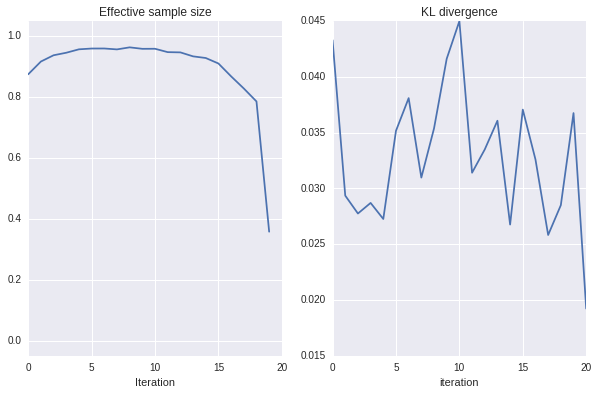

In [11]:
normal_path_smc.plot_diagnostics(output, path)

## Ising Model

In [12]:
alpha = 3.0
dimension = 100
ising_smc = MeanFieldIsingSampler(dimension, alpha)

In [13]:
N = 10**3
path = [(beta,) for beta in np.linspace(0,1,21)]
output = ising_smc.sampling(path, N, save_all_samples=True)

% complete:  10 25 40 55 70 85 100 
Elapsed time: 10.4 seconds.


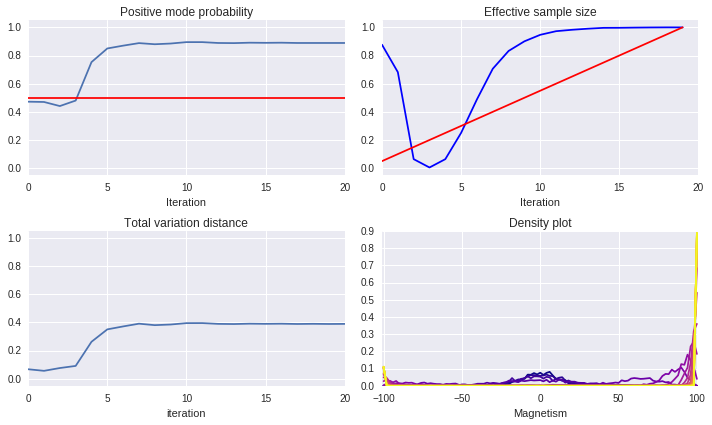

In [14]:
ising_smc.plot_diagnostics(output, path)

## Adaptive Ising Model

In [15]:
alpha = 3.0
dimension = 100
ising_smc = MeanFieldIsingSampler(dimension, alpha)

In [16]:
N = 1000
output = ising_smc.adaptive_sampling(N, 0.85)

% complete:  1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 49 52 55 58 61 64 67 70 73 76 79 82 85 88 91 94 97 100 
Elapsed time: 13.9 seconds.


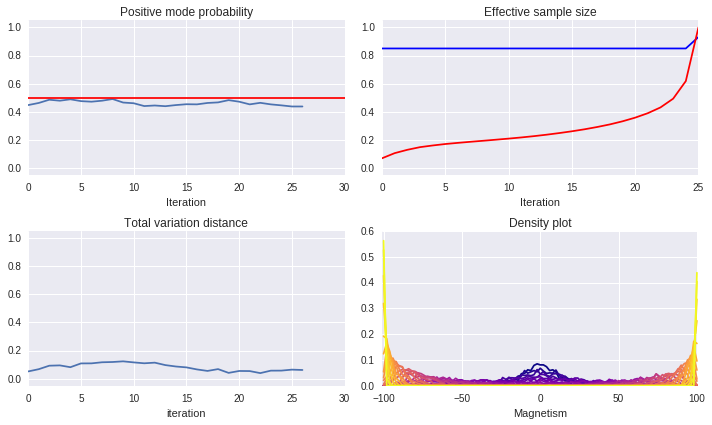

In [18]:
ising_smc.plot_diagnostics(output, output[-1])

## Logistic Regression

In [19]:
X, Y = load_pima_indians_data()
pima = LogisticRegressionSampler(X, Y, np.zeros(X.shape[1]), np.eye(X.shape[1])/0.01)

Loading Stan model...


In [20]:
S = 20
N = 1000
path = [(beta, 1.0) for beta in np.linspace(0,1,S+1)]
output = pima.sampling(path, N, save_all_samples=False)

% complete:  10 25 40 55 70 85 100 
Elapsed time: 70.4 seconds.


In [21]:
output[0].shape

(1000, 6)

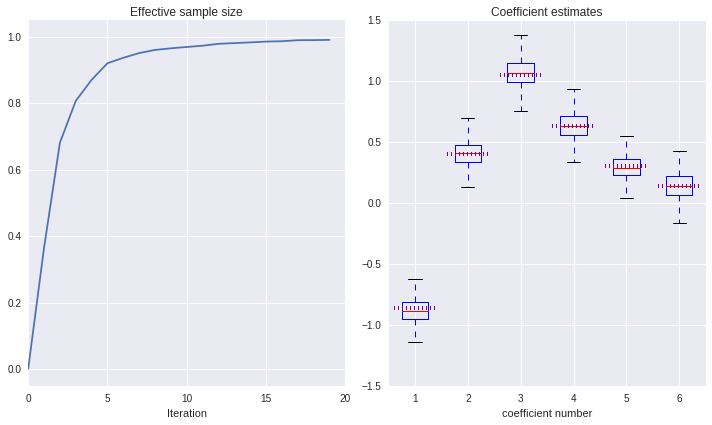

In [22]:
true_coefficients = np.array([-0.86, 0.4, 1.05, 0.63, 0.3, 0.14]) # estimated using 4mil run of stan
pima.plot_diagnostics(output, true_coefficients)

## Random Effects Model

In [23]:
n_observations = 100
n_groups = 20
alpha = 2.0
sigma = 0.5
tau = 2.0

re_sampler = RandomEffectsSampler(n_observations, n_groups, alpha, sigma, tau, 'geometric')

Loading Stan model...


In [24]:
path = [(beta,) for beta in np.linspace(0,0.1, 20)]
output = re_sampler.sampling(path, 1000, save_all_samples=False)

% complete:  10 31 52 73 94 100 
Elapsed time: 24.0 seconds.


In [25]:
data = {
    'n_observations': n_observations,
    'n_groups': n_groups,
    'groups': re_sampler.groups+1,
    'observations': re_sampler.observations,
    'beta': .0,
    'temperature': 1.0,
    'relax': 1.0
}
fit = re_sampler.stan_model.sampling(data=data, pars=['alpha', 'random_effects', 'tau', 'sigma'],iter=10**4)
true_parameters = fit.extract(permuted=False).reshape(-1,24)[:,:-1].mean(0)

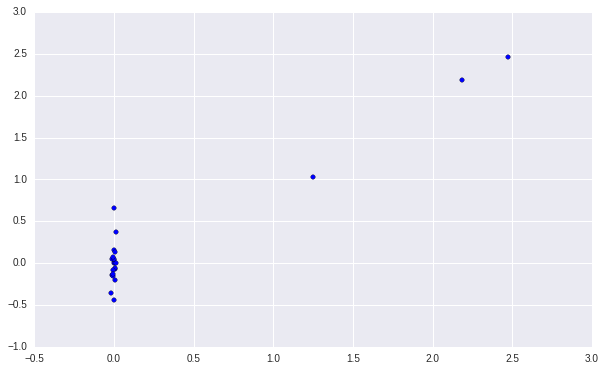

In [26]:
plt.scatter(true_parameters, output[0].mean(0))
plt.show()

## Linear regression variable selection sampler

In [27]:
rs = RegressionSelectionSampler(200, 30, 0.1, design_correlation=0.4)

In [28]:
betas = np.linspace(0,1,100)
path = [(beta, 1.0) for beta in betas]
ouput = rs.sampling(path, 1000)

% complete:  1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 49 52 55 58 61 64 67 70 73 76 79 82 85 88 91 94 97 100 
Elapsed time: 4.2 seconds.


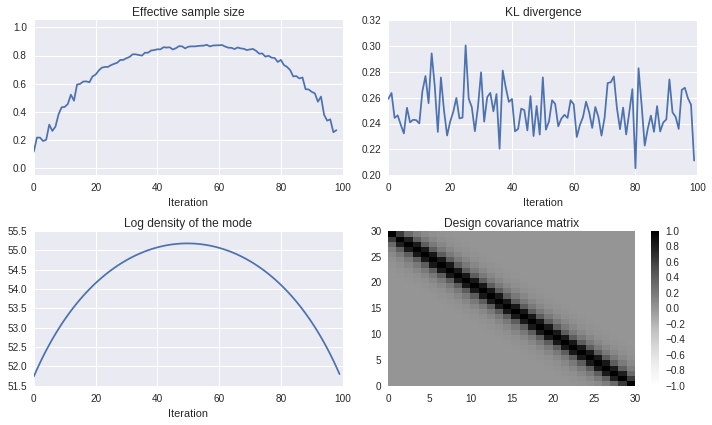

In [29]:
rs.plot_diagnostics(ouput, path)

In [40]:
test_dict = {'ca2t':5}
if 'cat' not in test_dict.keys():
    test_dict['cat']=2.0
test_dict

{'ca2t': 5, 'cat': 2.0}